## Getting the Data from Kaggle Using the Kaggle API

In [149]:
#!kaggle competitions download -c titanic

In [150]:
# Unzip the folder
#!unzip 'titanic.zip' -d data/titanic/

# Setup

In [272]:
# Load the train file to pandas
import pandas as pd
import numpy as np
import missingno as msno 
from collections import Counter
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

from subprocess import check_output
sns.set(style='white', context='notebook', palette='deep')
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()

# Load Data

In [273]:
data_dict = pd.read_csv("data/titanic/data_dictionary.csv")
data_dict

,Variable,Definition,Key
0,survival,Survival,"0 = No, 1 = Yes"
1,pclass,Ticket class,"1 = 1st, 2 = 2nd, 3 = 3rd"
2,sex,Sex,NaN
3,Age,Age in years,NaN
4,sibsp,# of siblings / spouses aboard the Titanic,NaN
5,parch,# of parents / children aboard the Titanic,NaN
6,ticket,Ticket number,NaN
7,fare,Passenger fare,NaN
8,cabin,Cabin number,NaN
9,embarked,Port of Embarkation,"C = Cherbourg, Q = Queenstown, S = Southampton"


In [274]:
titanic_train = pd.read_csv("data/titanic/train.csv")
titanic_test = pd.read_csv("data/titanic/test.csv")

# Getting the passengerID for test dataset so that we can split the 
# dataframe later by it. 
titanic_test_ID = titanic_test['PassengerId']

## Descriptive Statistics of the Dataset

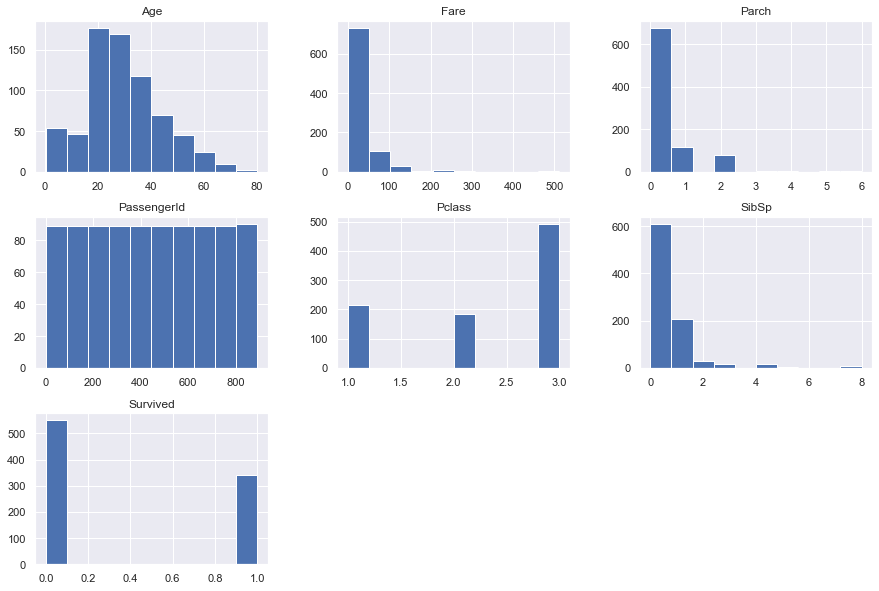

In [275]:
# Checking the distribution of each feature:
titanic_train.hist(figsize=(15,10));

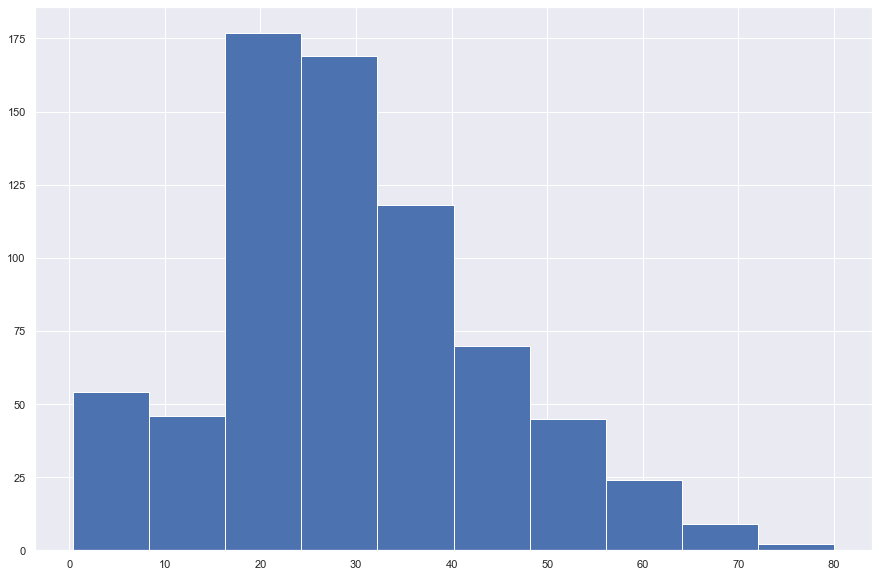

In [276]:
titanic_train["Age"].hist(figsize=(15,10));

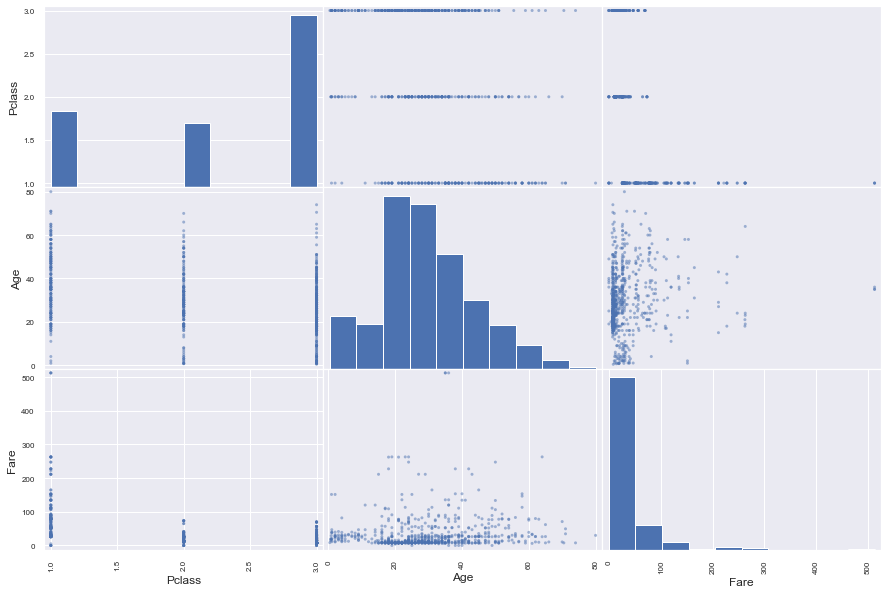

In [277]:
# Scatter Matrix to see the correlation between some of the features
from pandas.plotting import scatter_matrix
attributes = [ "Pclass", "Age", "Fare"]
scatter_matrix(titanic_train[attributes], figsize=(15,10));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


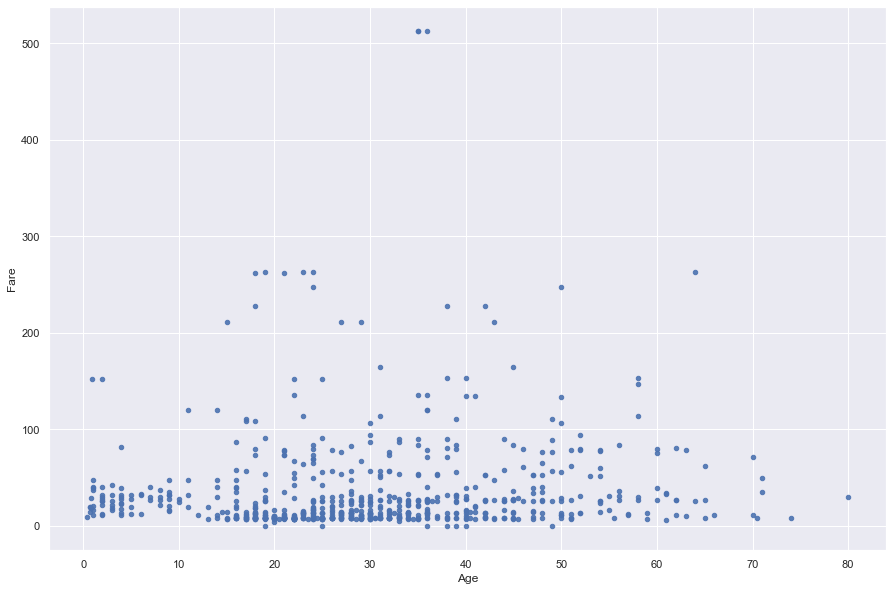

In [278]:
titanic_train.plot(kind="scatter", x="Age", y="Fare", alpha=0.9, figsize=(15,10));

In [279]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [280]:
# Looking for missing values
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Detecting Outliers

In this section, I am going to define a function that helps detect outliers in teh dataset (anything that falls out of 1.5* the IQR range). 

In [281]:

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(titanic_train,2,["Age","SibSp","Parch","Fare"])

In [161]:
titanic_train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [162]:
titanic_train = titanic_train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### Joining Train and Test datasets

Here, I am going to join both dataset for feature engineering and will later split them back using the titanic_test_ID. 

In [282]:
# Getting the length of the train dataset
len_titanic_train = len(titanic_train)
# We are stacking two datasets, so it's important to remember the order
df = pd.concat(objs=[titanic_train, titanic_test], axis=0).reset_index(drop=True)

### Missing Values

It looks like the Age, Embarked and Cabin columns having missing values. I assume that Age and Embarked columns could be more relevant than the cabin, so I am going to impute the Age column with the mean of the column grouped by PClass. 

In [283]:
# Inspecting some of the missing Age rows
df[df['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
1299,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
1301,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


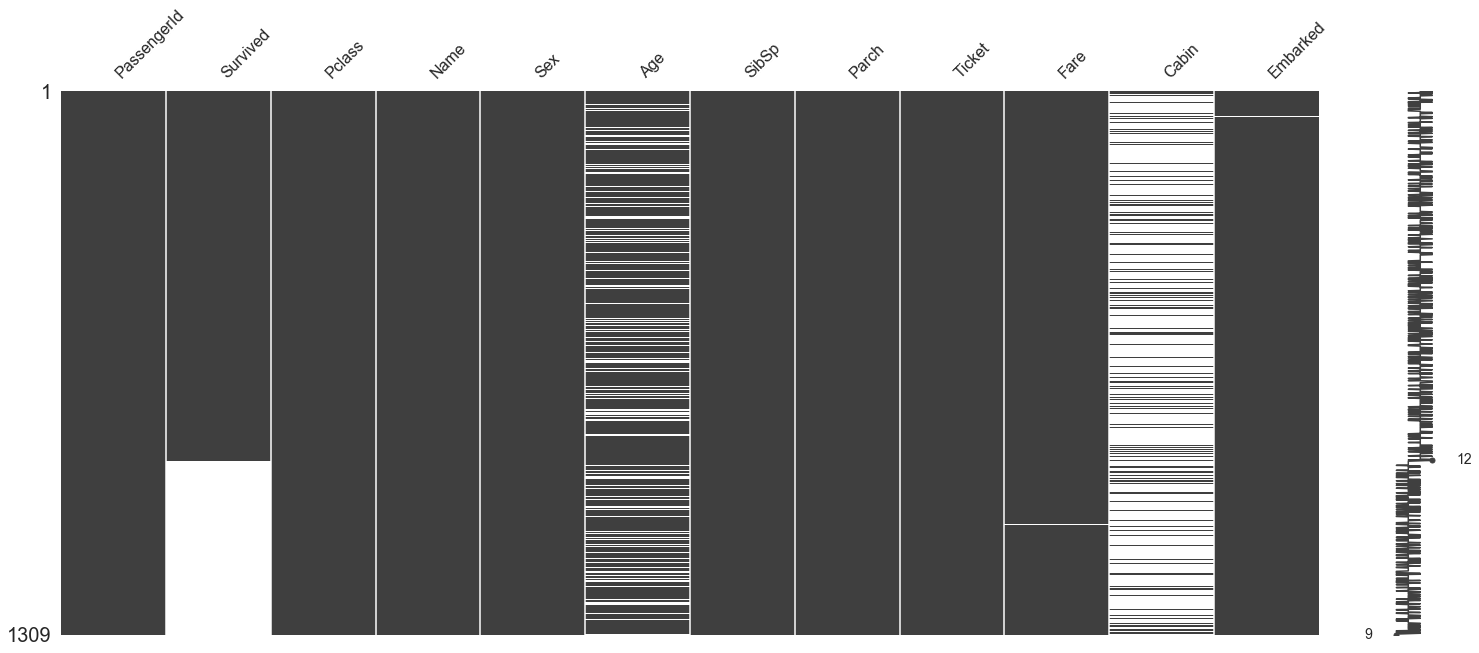

In [284]:
 # Visualize missing values as a matrix 
msno.matrix(df) 

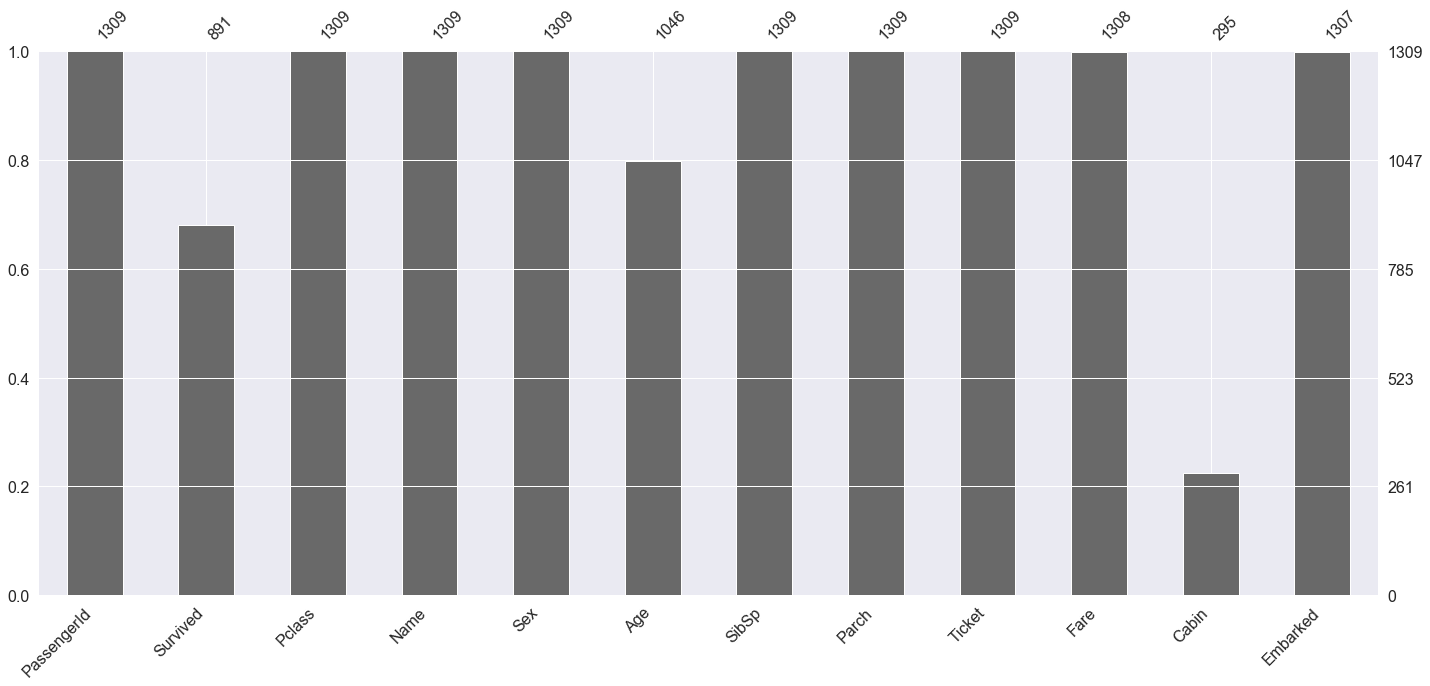

In [285]:
msno.bar(df) 

Let's see if there a correlation among the missing values in the data using the heatmap function of the missinno library.

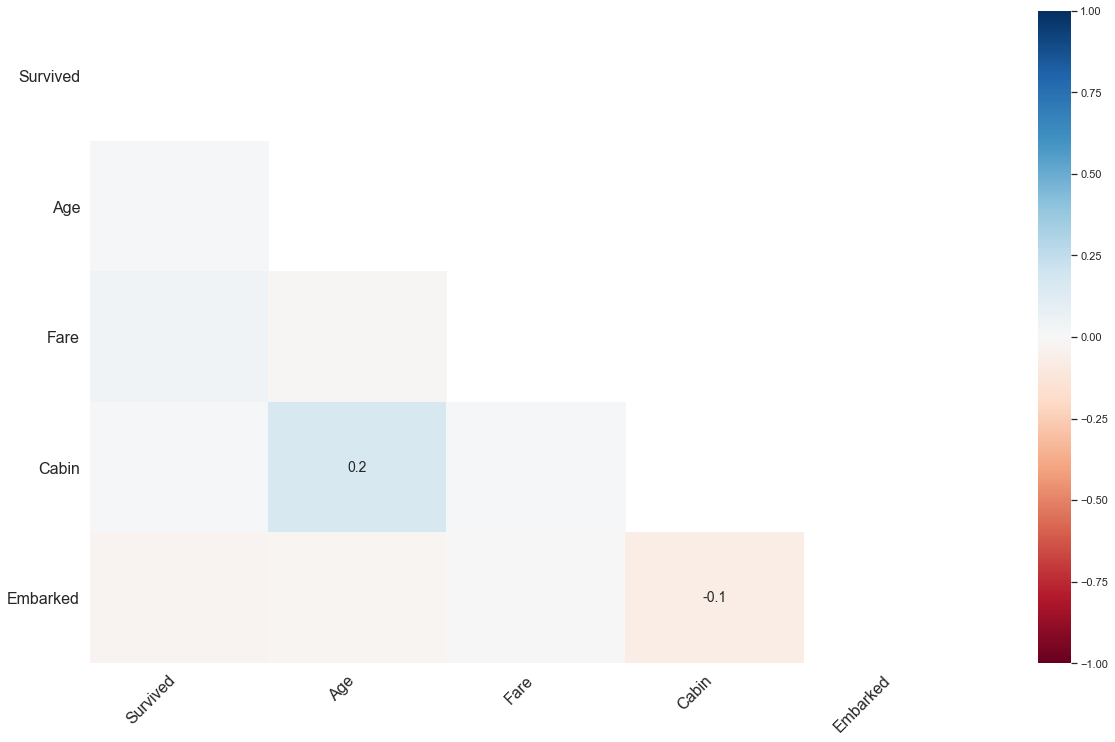

In [286]:
msno.heatmap(df);

From the heatmap above, it looks there is not a significant correlation between the missing values. 

### Imputing Missing Values

##### Impute Age

For the Age column, we can impute the missing values by the mean value of each group by Sex and Pclass. 

In [287]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(df["Age"][df["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = df["Age"].median()
    age_pred = df["Age"][((df['SibSp'] == df.iloc[i]["SibSp"]) & (df['Parch'] == df.iloc[i]["Parch"]) & (df['Pclass'] == df.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        df['Age'].iloc[i] = age_pred
    else :
        df['Age'].iloc[i] = age_med

##### Impute Fare

In [290]:
# Let's fill the null values with the median value
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

##### Impute Cabin

In [293]:
df['Cabin_mapped'] = df['Cabin'].astype(str).str[0]
# this transforms the letters into numbers
cabin_dict = {k:i for i, k in enumerate(df.Cabin_mapped.unique())} 
df.loc[:, 'Cabin_mapped'] = df.loc[:, 'Cabin_mapped'].map(cabin_dict)

In [294]:
# Let's inspect cabins and see how they are labeled
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [295]:
df['Cabin'].isnull().sum()

1014

In [296]:
# We can try to replace the Cabin with X for missing
# Replace the Cabin number by the type of cabin 'X' if not
df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin'] ])

##### Impute Embarked

In [297]:
# Let's inspect the embarked column and see which rows have missing records
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_mapped
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B,NaN,6
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B,NaN,6


In [298]:
# Embarked
# We can impute this feature with the mode which is S
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [299]:
# Checking to see if the above function worked: 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   1309 non-null   int64  
 1   Survived      891 non-null    float64
 2   Pclass        1309 non-null   int64  
 3   Name          1309 non-null   object 
 4   Sex           1309 non-null   object 
 5   Age           1309 non-null   float64
 6   SibSp         1309 non-null   int64  
 7   Parch         1309 non-null   int64  
 8   Ticket        1309 non-null   object 
 9   Fare          1309 non-null   float64
 10  Cabin         1309 non-null   object 
 11  Embarked      1309 non-null   object 
 12  Cabin_mapped  1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB


In [300]:

def draw_heatmap(df, y_variable, no_features):
    """ This Function takes three arguments; 
        1. The dataframe that we want to draw the heatmap for
        2. The variable that we want to see the correlation of with other features for example the y-variable.
        3. The top_n. For example for top 10 variables, type 10."""
    # Calculate the correlation matrix
    cor = df.corr()
    # Get the columns for n largetst features
    columns = cor.nlargest(no_features, y_variable)[y_variable].index
    cm = np.corrcoef(df[columns].values.T)
    sns.set(font_scale=1)
    fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    # Define the color pallet
    cmap = sns.cm.vlag_r
    heat_map = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={'size':12}, 
                      yticklabels=columns.values, xticklabels=columns.values,
                      linewidths=.2,vmax=1, center=0, cmap= cmap)
    return plt.show();

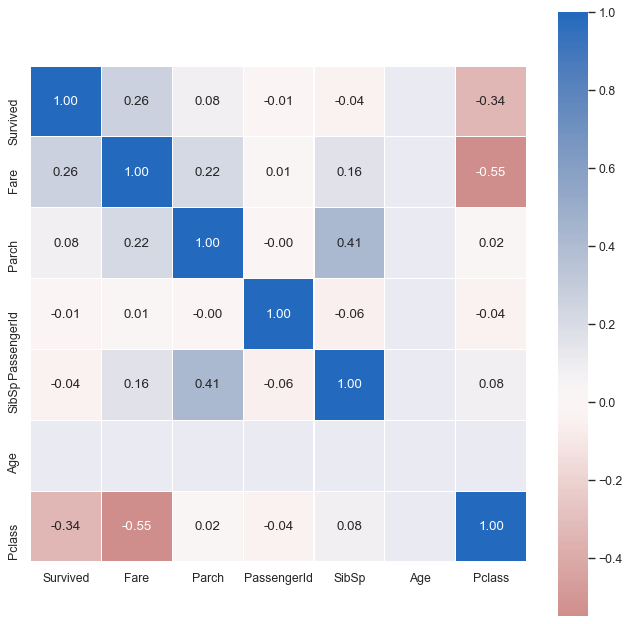

In [301]:
draw_heatmap(titanic_train, 'Survived', 10)

We could see that that Fare and age has higher negative correlations. This means that there might hidden patterns within each feature and some feature engineering, that we could see different heatmap

# Feature Analysis

For Feature Analysis, I am going to define three helper functions that are going to help in drawing plots. I am planning ot Seaborn's Factoplots and Pandas' Barcharts. 

In [302]:
def plot_factorplot(df, x, y='Survived', hue=None):
    import warnings
    warnings.simplefilter(action='ignore', category=Warning)
    plt.figure(figsize=(12,10))
    g  = sns.factorplot(x=x,y=y,data=df,kind="bar", size = 6 , hue=hue, palette = "muted")
    g.despine(left=True)
    g = g.set_ylabels("Survival Probability")
    g = g.set_xlabels("{}".format(x))

In [303]:
def plot_barchart(df, feature):
    """ This functions takes the feature that we want to plot against survivors"""
    survived = df[df['Survived']==1][feature].value_counts()
    not_survived = df[df['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,not_survived])
    df.index=['Survived','Not Survived']
    df.plot(kind='bar',stacked=False,title="Stacked Chart for  "+feature, figsize=(12,10))

In [304]:
def plot_distribution(df, col, **options):
    from scipy.stats import norm

    """
    This function helps draw a distribution plot for the desired colum.
    Input args: 
    1. df : Dataframe that we want to pick the column from. 
    2. col : Column of the dataframe that we want to display.
    3. options:
        a. kde : optional, boolian - Whether to plot a gaussian kernel density estimate.
        b. fit : An object with `fit` method, returning a tuple that can be passed to a `pdf` method a 
        positional arguments following a grid of values to evaluate the pdf on.
    """
    plt.figure(figsize=(12,10))
    plt.ylabel("Frequency")
    plt.title("{} Distribution".format(col))
    if options.get("kde")==True:
        sns.distplot(df[col], kde=True, color="#2b7bba");
    if options.get("fit")== "norm":
        (mu, sigma) = norm.fit(df[col])
        sns.distplot(df[col], fit=norm, color="#2b7bba");
        plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)],
                  loc='best');
        
    if (options.get("fit")== "norm") & (options.get("kde")==True):
        sns.distplot(df[col], fit=norm, kde=True, color="#2b7bba");
    else:
        sns.distplot(df[col], color="#2b7bba");

##### Sex

In [305]:
survivors_data = titanic_train[titanic_train.Survived==True]
non_survivors_data = titanic_train[titanic_train.Survived==False]

In [306]:
Gender = pd.crosstab(titanic_train['Survived'],titanic_train['Sex'])
Gender

Sex,female,male
Survived,,
0,81,468
1,233,109


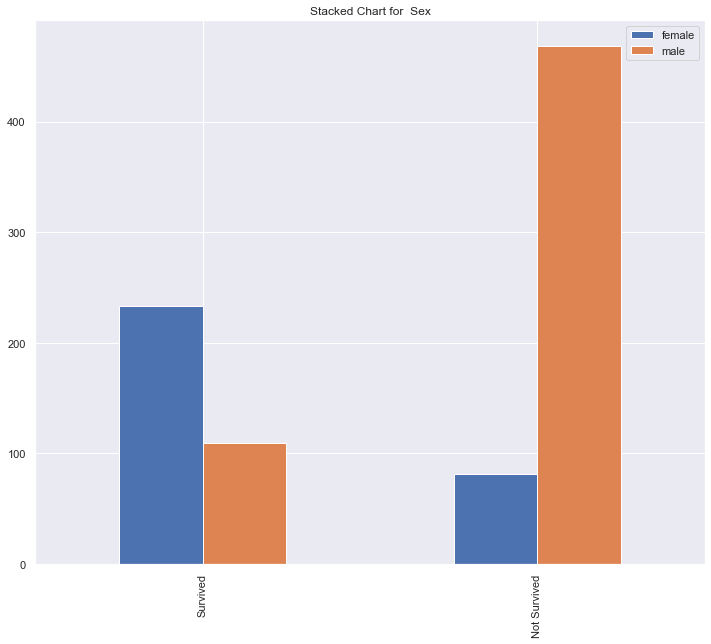

In [307]:
plot_barchart(titanic_train,"Sex")

We could see that females had a higher chance of survival than the males. It looks like Sex might be an important factor in determining the chance of survival. We can create some features for that. 


##### Pclass

In [308]:
Pclass = pd.crosstab(titanic_train['Survived'],titanic_train['Pclass'])
Pclass

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


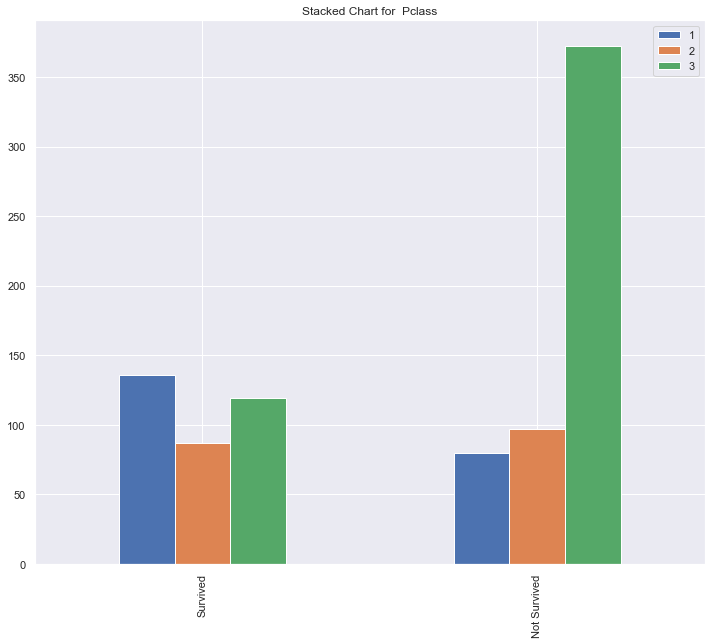

In [309]:
plot_barchart(titanic_train, "Pclass")

We can see in the above chart that passengers with with tickets in class 3 had a less survival chance.

<Figure size 864x720 with 0 Axes>

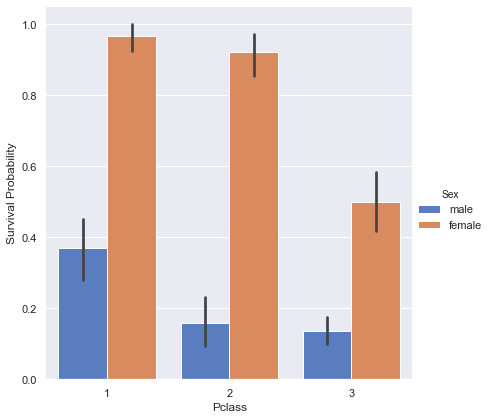

In [310]:
# Explore Pclass vs Survived by Sex
plot_factorplot(titanic_train, "Pclass", hue='Sex')

We could see that Pclass and sex both have role in determining survival. We could see that within females, the ones with the ticket class 1 and 2 had a higher survival chance. 

##### Fare

Let's see the distribution of the fare

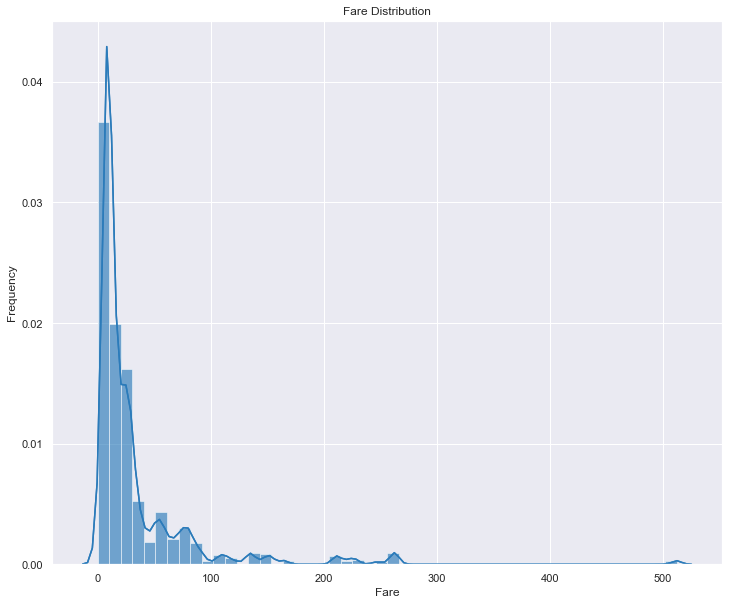

In [311]:
#Explore Fare distribution 
plot_distribution(df, "Fare", kde=True)

We can see that the fare is skewed positively. We can fix this by transforming the fare feature with a logarithmic transformation function

#### Transform Fare

In [312]:
df['Fare'] = np.log1p(df['Fare'])

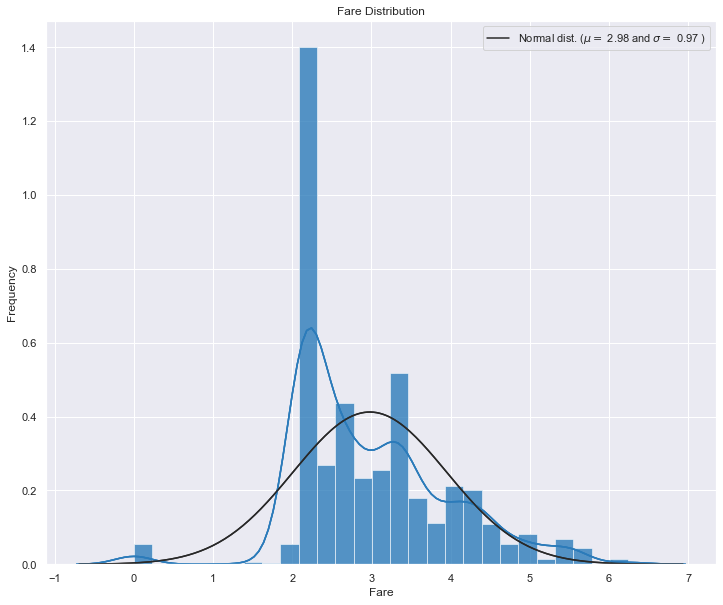

In [313]:
# Let's display the distribution after log transformation
plot_distribution(df, "Fare", kde=True, fit="norm")

##### Age

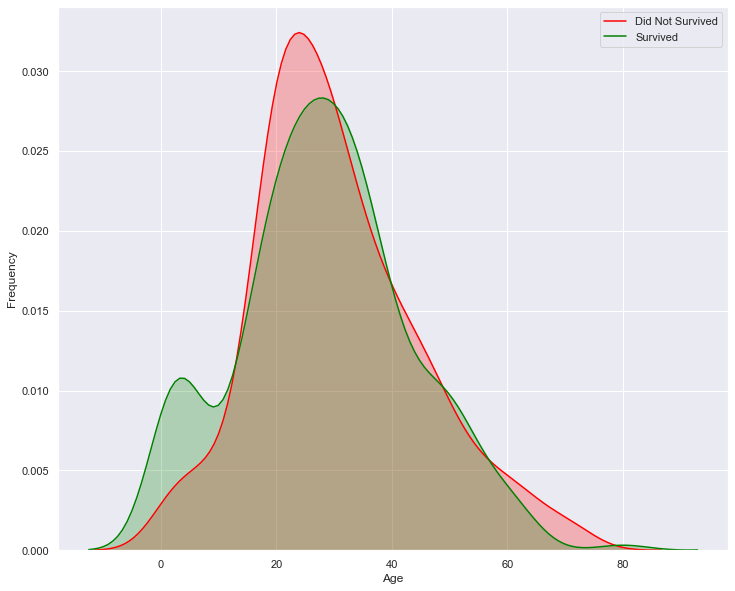

In [314]:
# Explore Age distibution 
fig  = plt.figure(figsize=(12,10))
g = sns.kdeplot(titanic_train["Age"][(titanic_train["Survived"] == 0) & (titanic_train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(titanic_train["Age"][(titanic_train["Survived"] == 1) & (titanic_train["Age"].notnull())], ax =g, color="Green", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Did Not Survived","Survived"])

After plotting the survival by age, we can see that there high survial for teens and also on the right tail we can see that people above 70 have survived higher. 

##### SibSP

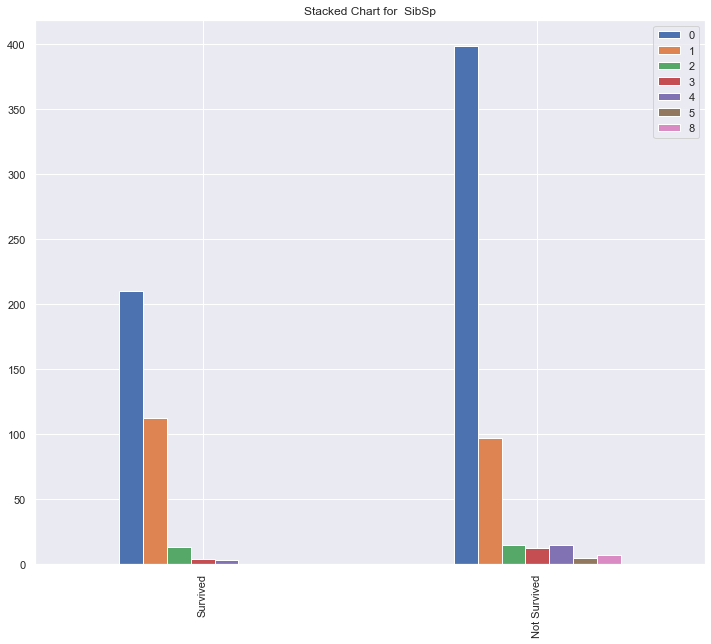

In [315]:
plot_barchart(titanic_train, "SibSp")

It looks like the passengers having more siblings/spouses had a higher chance of not surviving. On the other hand, single passengers were more likely to survive. 

##### Parch

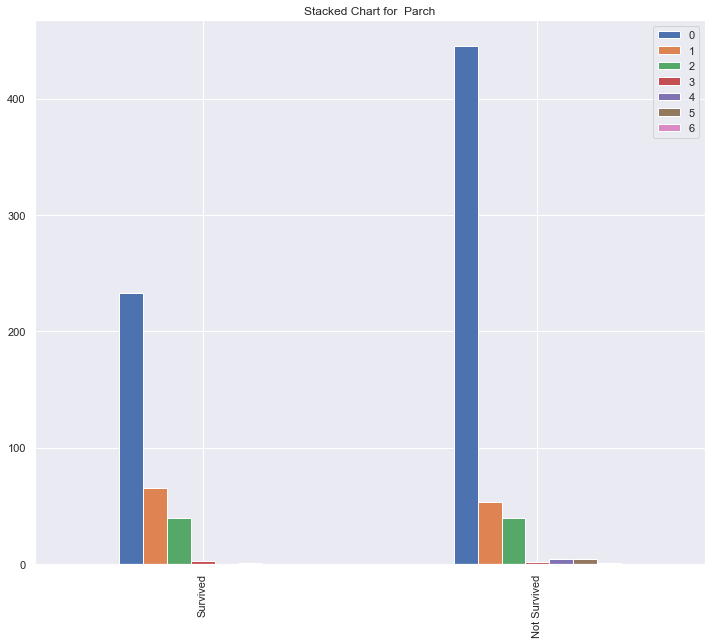

In [316]:
plot_barchart(titanic_train, "Parch")

<Figure size 864x720 with 0 Axes>

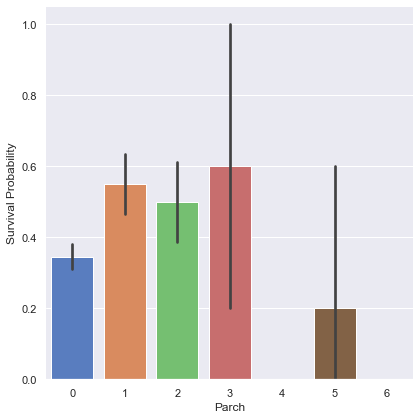

In [317]:
# Explore Parch feature vs Survived
plot_factorplot(titanic_train, 'Parch')

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).

##### Embarked

<Figure size 864x720 with 0 Axes>

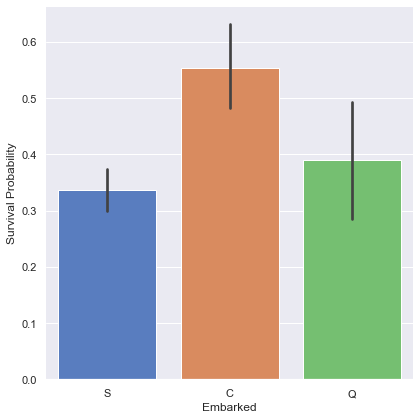

In [318]:
plot_factorplot(titanic_train, 'Embarked')

We can see that passengers embarking the ship from Southhampton (S) had the lowest survival rate, however, passengers embarking from Cherbourg(C) had the highest chance of survival. 

Let's look a little deeper and see if the passengers from C had more Class 1 tickets.

<Figure size 864x720 with 0 Axes>

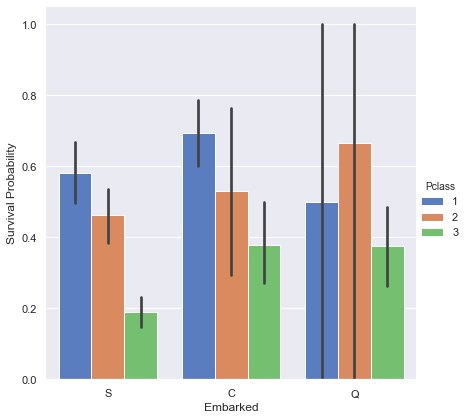

In [319]:
plot_factorplot(titanic_train,'Embarked', hue='Pclass')

We can see that passengers from C had more 1st class tickets compared those those from S.

## Feature Engineering

####  Pclass
We can convert Sex to categorical and then to dummy. 

In [196]:
# Create categorical values for Pclass
df["Pclass"] = df["Pclass"].astype("category")
df = pd.get_dummies(df, columns = ["Pclass"],prefix="Pc")

####  Sex
We can convert Sex to categorical

In [197]:
df['Sex'] = df['Sex'].map({'male': 0, 'female':1})

#### Family Size

We can try to calculate a feature called family size where we are adding Parch, SibSp and 1 for the passenger him/herself

In [198]:
df['Fam_size'] = 1 + df['Parch'] + df['SibSp']

<Figure size 864x720 with 0 Axes>

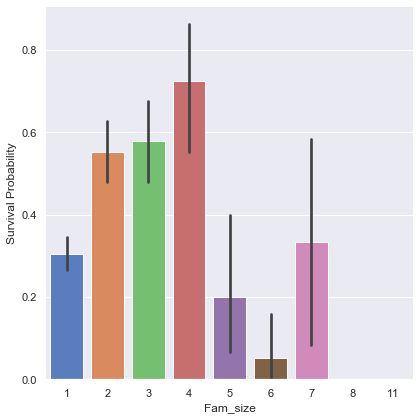

In [199]:
plot_factorplot(df, 'Fam_size')

We can see that that familyi size have some effect on the survival. 

In [200]:
# Create new feature of family size
df['Single'] = df['Fam_size'].map(lambda s: 1 if s == 1 else 0)
df['SmallF'] = df['Fam_size'].map(lambda s: 1 if  s == 2  else 0)
df['MedF'] = df['Fam_size'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['Fam_size'].map(lambda s: 1 if s >= 5 else 0)

#### Title

We can see that some of the passenger names have titles in fron them. This may add predicive power to the survival rate. Let's extract their titles and convert it into a dummy variable.

In [202]:
df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [203]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [204]:
df['Title']=df['Name'].apply(get_title)
title_lev=list(df['Title'].value_counts().reset_index()['index'])

In [206]:
df['Title']=pd.Categorical(df['Title'], categories=title_lev)

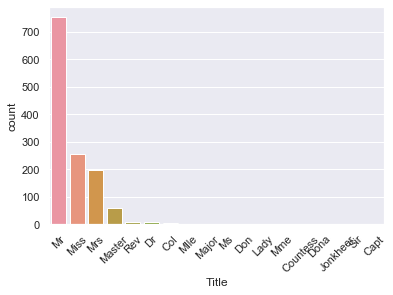

In [138]:
g = sns.countplot(x="Title",data=df)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [209]:
df = pd.get_dummies(df, columns=['Title'], drop_first=True, prefix="Title")

In [210]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Pc_1', 'Pc_2', 'Pc_3',
       'Fam_size', 'Single', 'SmallF', 'MedF', 'LargeF', 'Title_Miss',
       'Title_Mrs', 'Title_Master', 'Title_Rev', 'Title_Dr', 'Title_Col',
       'Title_Mlle', 'Title_Major', 'Title_Ms', 'Title_Don', 'Title_Lady',
       'Title_Mme', 'Title_Countess', 'Title_Dona', 'Title_Jonkheer',
       'Title_Sir', 'Title_Capt'],
      dtype='object')

In [211]:
# Drop the name column
df = df.drop(['Name'], axis=1)

We can that passengers with Miss-Mrs had a higher chance of survival. 

In [214]:
df.columns

Index(['PassengerId', 'Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Pc_1', 'Pc_2', 'Pc_3', 'Fam_size',
       'Single', 'SmallF', 'MedF', 'LargeF', 'Title_Miss', 'Title_Mrs',
       'Title_Master', 'Title_Rev', 'Title_Dr', 'Title_Col', 'Title_Mlle',
       'Title_Major', 'Title_Ms', 'Title_Don', 'Title_Lady', 'Title_Mme',
       'Title_Countess', 'Title_Dona', 'Title_Jonkheer', 'Title_Sir',
       'Title_Capt'],
      dtype='object')

#### Ticket

We can try to extract some information from the ticket feature by extracting it's prefix. We can use X for those that don't have a prefix. 

In [215]:
df['Ticket']

0                A/5 21171
1                 PC 17599
2         STON/O2. 3101282
3                   113803
4                   373450
               ...        
1294             A.5. 3236
1295              PC 17758
1296    SOTON/O.Q. 3101262
1297                359309
1298                  2668
Name: Ticket, Length: 1299, dtype: object

In [216]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(df.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
df["Ticket"] = Ticket
df["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [217]:
df = pd.get_dummies(df, columns = ["Ticket"], prefix="T")


In [218]:
df.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Pc_1,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,1,0.0,0,22.0,1,0,2.110213,X,S,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1,38.0,1,0,4.280593,C,C,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,1,26.0,0,0,2.188856,X,S,0,...,0,0,0,0,1,0,0,0,0,0
3,4,1.0,1,35.0,1,0,3.990834,C,S,1,...,0,0,0,0,0,0,0,0,0,1
4,5,0.0,0,35.0,0,0,2.202765,X,S,0,...,0,0,0,0,0,0,0,0,0,1


#### Embarked

Let's convert this categorical to numerical using Pandas' get_dummies function

In [219]:
df = pd.get_dummies(df, columns=['Embarked'], prefix="Embarked")

#### Cabin

Let's convert this categorical to numerical using Pandas' get_dummies function

In [220]:
df['HasCabin'] = df['Cabin'].apply(lambda x: 0 if x==0 else 1)
df = pd.get_dummies(df, columns=['Cabin'], prefix="Cabin")

In [221]:
df = pd.get_dummies(df, columns=['HasCabin'], prefix="CabinBol")

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 82 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     1299 non-null   int64  
 1   Survived        881 non-null    float64
 2   Sex             1299 non-null   int64  
 3   Age             1299 non-null   float64
 4   SibSp           1299 non-null   int64  
 5   Parch           1299 non-null   int64  
 6   Fare            1299 non-null   float64
 7   Pc_1            1299 non-null   uint8  
 8   Pc_2            1299 non-null   uint8  
 9   Pc_3            1299 non-null   uint8  
 10  Fam_size        1299 non-null   int64  
 11  Single          1299 non-null   int64  
 12  SmallF          1299 non-null   int64  
 13  MedF            1299 non-null   int64  
 14  LargeF          1299 non-null   int64  
 15  Title_Miss      1299 non-null   uint8  
 16  Title_Mrs       1299 non-null   uint8  
 17  Title_Master    1299 non-null   u

In [320]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_mapped'],
      dtype='object')

In [224]:
df = df.drop(labels = ["PassengerId", "Parch", "Fam_size"],axis = 1)

In [225]:
df.columns

Index(['Survived', 'Sex', 'Age', 'SibSp', 'Fare', 'Pc_1', 'Pc_2', 'Pc_3',
       'Single', 'SmallF', 'MedF', 'LargeF', 'Title_Miss', 'Title_Mrs',
       'Title_Master', 'Title_Rev', 'Title_Dr', 'Title_Col', 'Title_Mlle',
       'Title_Major', 'Title_Ms', 'Title_Don', 'Title_Lady', 'Title_Mme',
       'Title_Countess', 'Title_Dona', 'Title_Jonkheer', 'Title_Sir',
       'Title_Capt', 'T_A', 'T_A4', 'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS', 'T_C',
       'T_CA', 'T_CASOTON', 'T_FC', 'T_FCC', 'T_Fa', 'T_LINE', 'T_LP', 'T_PC',
       'T_PP', 'T_PPP', 'T_SC', 'T_SCA3', 'T_SCA4', 'T_SCAH', 'T_SCOW',
       'T_SCPARIS', 'T_SCParis', 'T_SOC', 'T_SOP', 'T_SOPP', 'T_SOTONO2',
       'T_SOTONOQ', 'T_SP', 'T_STONO', 'T_STONO2', 'T_STONOQ', 'T_SWPP',
       'T_WC', 'T_WEP', 'T_X', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_X', 'CabinBol_1'],
      dtype='object')

In [321]:
cols = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex','Cabin_mapped', 'Embarked', 'Survived', 'Age']
df = df[cols]

In [323]:
df = pd.get_dummies(df, columns=['Sex', 'Cabin_mapped', 'Embarked'],drop_first=True)

# Modeling

In [325]:
# Let's split the train and test data sets
train = df[:len_titanic_train]
test = df[len_titanic_train:]

# Drop the empty Survived column from the test dataset. 
test.drop(labels=['Survived'], axis=1, inplace=True)

In [326]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

y = train["Survived"]

X = train.drop(labels = ["Survived"],axis = 1)

#### Split Test Train Data

Here, I am going to split the data into training and validation sets using Scikit-Learn. 

In [327]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Model

For the first run, I am going to try Random Forest Classifier using GridSearch. 

In [328]:
# Istentiate the model
rfc=RandomForestClassifier(random_state=42, n_jobs=4)

In [347]:
# Parameter for our classifier
param_grid = { 
    'n_estimators': [100,150, 200, 500, 600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2, 4,5,6,7,8, 9, 10, 11, 12, 13, 14, 18],
    'criterion' :['gini', 'entropy']
}

In [348]:
# Defining our Gridsearch cross validation
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

In [350]:
# Fitting the GridSearch to training and testing. 
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=4,
                                              oob_score=False, random_state=42,
                                     

In [351]:
# Looking the best parameters. 
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 'auto',
 'n_estimators': 500}

In [342]:
# Now, we can use the parameters above to define our model. 
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, 
                            max_depth=12, criterion='entropy', n_jobs=6)

In [343]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=6,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [344]:
test_predictions = rfc1.predict(test)

In [345]:
submission = pd.DataFrame()
submission['PassengerId'] = titanic_test['PassengerId']
submission['Survived'] = test_predictions

In [346]:
submission.to_csv("data/titanic/submission.csv", index=False)


#### XGBoost

In [244]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [245]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [246]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [252]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', 
                                   n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )

# Here we go
random_search.fit(X, y)
#roc_auc

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    6.6s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000022690D2E0C8>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child...
                                           subsample=None, tree_method=None,
                                           validate_parameters=False,
                                           verbosity=None),
                   iid='deprecated', n_

In [266]:
submission = pd.DataFrame()
submission['PassengerId'] = titanic_test['PassengerId']
submission['Survived'] = test_predictions
submission.to_csv("data/titanic/submission.csv", index=False)

### Ongoing work! 

I am still trying to improve my Kaggle Score. I will continue using the following models. 

In [268]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}

# Instantiate the regressor: gbm
gbm = XGBClassifier(n_estimators=10)

# Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 50, cv = 4)


# Fit randomized_mse to the data
xgb_random.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters found:  {'n_estimators': 9, 'max_depth': 7, 'learning_rate': 0.4, 'colsample_bytree': 0.8}
Best accuracy found:  0.8354586589880708


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.2s finished


In [269]:
xgb_pred = xgb_random.predict(test)

In [271]:
submission = pd.DataFrame()
submission['PassengerId'] = titanic_test['PassengerId']
submission['Survived'] = xgb_pred
submission.to_csv("data/titanic/submission.csv", index=False)